# Introduction

### Problem Description

The problem of [surrogate modelling](https://en.wikipedia.org/wiki/Surrogate_model) is as follows. There are several control variables that can be changed by a decision maker and the goal is to find optimal vector of control variables' values, but a loss to be minimized is hard to measure and so its values are available only on limited amount of control variables' vectors. The approach of surrogate modelling lies in building a model that approximates the loss function on the whole set of available inputs and is based on available data. Then a minimum point of loss function's approximation is regarded as minimum point of real loss.

Let us provide an example of situation where surrogate modelling is appropriate. Suppose that engineers are going to create new alloy of two metals and these engineers have two control variables: proportion of one metal to the other and intensity of heat treatment. Assume also that a loss is fragility of alloy. Engineers can produce pieces of various alloys that are obtained with several values of control variables and test them empirically, but this procedure is expensive. After some data are gathered, it is possible to build an approximation of fragility function and then test an alloy that corresponds to its minimum point.

In this notebook, machine learning approach is used for surrogate modelling of some functions of two variables. Note that tree-based ensembles are not involved here, because they can not make a prediction that is below target's minimum over training sample or above target's maximum over training sample and, in particular, they can not extrapolate trends.

### Software Requirements

This notebook does not use any packages beyond a list of those that are quite popular in scientific computing. Use conda or pip to install any of them.

# General Preparations

In [1]:
from functools import partial

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import keras
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [2]:
np.random.seed(361)

# Template of Experiments

### Designs of Experiments

Since functions of just two arguments are studied here, there is no curse of dimensionality. Hence, complex designs such as [Latin hypercubes](https://en.wikipedia.org/wiki/Latin_hypercube_sampling), [Sobol sequences](https://en.wikipedia.org/wiki/Sobol_sequence), or [Halton sequences](https://en.wikipedia.org/wiki/Halton_sequence) are not necessary. Only two designs are used:
* Random sampling from uniform distribution on a constrained segment of domain;
* Grid of particular size and equal steps. 

In [3]:
def draw_from_uniform_distribution(n_samples, x_borders, y_borders):
    """
    Draws `n_samples` from a uniform
    distribution on a rectangle that is
    a Cartesian product of intervals with
    ends represented by `x_borders` and
    `y_borders` respectively.
    
    @type n_samples: int
    @type x_borders: tuple(float)
    @type y_borders: tuple(float)
    @rtype: numpy.ndarray
    """
    xs = np.random.uniform(x_borders[0], x_borders[1], n_samples).reshape((-1, 1))
    ys = np.random.uniform(y_borders[0], y_borders[1], n_samples).reshape((-1, 1))
    return np.hstack((xs, ys))

In [4]:
def create_grid(step, left_bottom_corner, x_n_steps, y_n_steps):
    """
    Returns array of points from a rectangular
    grid with `step` as vertical or horizontal
    distance between adjacent nodes. Size of
    grid is determined by `x_n_steps` and
    `y_n_steps`, while its location is determined
    via `left_bottom_corner`.
    
    @type step: float
    @type left_bottom_corner: tuple(float)
    @type x_n_steps: int
    @type y_n_steps: int
    @rtype: numpy.ndarray
    """
    xs = [left_bottom_corner[0] + i * step for i in range(x_n_steps)]
    ys = [left_bottom_corner[1] + i * step for i in range(y_n_steps)]
    return np.transpose([np.tile(xs, len(ys)), np.repeat(ys, len(xs))])

Actually, brute force with above designs is used for surrogate loss optimization. Again, more complex techniques (e.g. gradient-based optimization) are not used, because a problem is computationally feasible due to low dimensionality.

### Runner

In [5]:
class RunnerOfSurrogateModelling(object):
    """
    Structurizes utilities that are useful
    for the following experiment. Given a
    function of two real-valued arguments
    `func` (actually, `func` must have also
    an optional argument `noise_stddev`),
    learning sample for this function recovery
    is drawn from an experiment that is
    designed in accordance with `measurement_doe`.
    Then `model` is trained to approximate `func`
    and its optimum is found in accordance
    with `optimization_doe`.
    """
    
    def __init__(self, func, noise_stddev, model,
                 measurement_doe, optimization_doe, **kwargs):
        """
        @type func: function
        @type noise_stddev: float
        @type model: keras.Model
        @type measurement_doe: str
        @type optimization_doe: str
        """
        self.func = func
        self.model = model
        
        if measurement_doe == 'random':
            self.draw_measurements = draw_from_uniform_distribution
        elif measurement_doe == 'grid':
            self.draw_measurements = create_grid
        else:
            raise ValueError("Unknown `measurement_doe`: {}".format(measurement_doe))
            
        if optimization_doe == 'random':
            self.draw_candidates = draw_from_uniform_distribution
        elif optimization_doe == 'grid':
            self.draw_candidates = create_grid
        else:
            raise ValueError("Unknown `optimization_doe`: {}".format(optimization_doe))
            
        train_inputs = self.draw_measurements(**kwargs)
        self.train_data = pd.DataFrame(train_inputs, columns=['x', 'y'])
        self.train_data['target'] = self.train_data.apply(
            lambda row: self.func(row['x'], row['y'], noise_stddev), axis=1)
        
        self.goodness_of_fit = None
        self.minimum_point = None
        self.actual_value_at_surrogate_optimum = None
        self.benchmark = None
        
    def _train_surrogate_model(self, **kwargs):
        """
        Fits `self.model` to `self.train_data`
        with specified hyperparameters.
        
        @rtype: NoneType
        """
        X_train, X_test, y_train, y_test = \
            train_test_split(self.train_data[['x', 'y']].as_matrix(),
                             self.train_data['target'].as_matrix(),
                             random_state=361)
        # TODO: turn off verbosity before push to master
        hst = self.model.fit(X_train, y_train, validation_data=(X_test, y_test),
                             callbacks=[keras.callbacks.History()], verbose=1, **kwargs)
        self.goodness_of_fit = (hst.history['loss'][-1], hst.history['val_loss'][-1])
        
    def _visualize_target_vs_surrogate(self, **kwargs):
        """
        Plots two graphs near each other.
        
        @rtype: NoneType
        """
        df = pd.DataFrame(create_grid(**kwargs), columns=['x', 'y'])
        df['target'] = df.apply(
            lambda row: noisy_himmelblaus_function(row['x'], row['y'], noise_stddev=0),
            axis=1)
        df['surrogate'] = df.apply(
            lambda row: self.model.predict(row[['x', 'y']].as_matrix().reshape((1, 2)))[0, 0],
            axis=1)
        
        fig = plt.figure(figsize=(15, 7))
        
        ax_one = fig.add_subplot(121)
        ax_one.scatter(df['x'], df['y'], c=df['target'], cmap='coolwarm')
        ax_one.set_title('Actual function')
        ax_one.set_aspect('equal')
        
        # TODO: unify colormap scale.
        ax_two = fig.add_subplot(122)
        ax_two.scatter(df['x'], df['y'], c=df['surrogate'], cmap='coolwarm')
        ax_two.set_title('Surrogate function')
        ax_two.set_aspect('equal')
        
    def _compute_benchmark(self):
        """
        Computes benchmark that is a score at
        a minimum point of (in general, noisy)
        measured target. Ties in values of the
        measured target are broken at random.
        
        @rtype: NoneType
        """
        cond = self.train_data['target'] == self.train_data['target'].min()
        potential_inputs = self.train_data.loc[cond, ['x', 'y']]
        inputs = potential_inputs.sample(random_state=361).iloc[0, :]
        self.benchmark = self.func(inputs['x'], inputs['y'], noise_stddev=0)
    
    def _find_minimum_of_surrogate_target(self, **kwargs):
        """
        Finds a point with the lowest prediction
        of `self.model` amongst points that are
        obtained in accordance with
        `self.optimization_doe`.
        Ties are broken by random choice.
        
        @rtype: NoneType
        """
        candidates = self.draw_candidates(**kwargs)
        candidates = pd.DataFrame(candidates, columns=['x', 'y'])
        candidates['surrogate_target'] = candidates.apply(
            lambda row: self.model.predict(row.as_matrix().reshape((1, 2)))[0, 0],
            axis=1)
        
        cond = candidates['surrogate_target'] == candidates['surrogate_target'].min()
        minimum_points = candidates.loc[cond, ['x', 'y']]
        self.minimum_point = minimum_points.sample(random_state=361).iloc[0, :]
        self.minimum_point = self.minimum_point.as_matrix().reshape((1, 2))
        self.actual_value_at_surrogate_optimum = self.func(
            self.minimum_point[0, 0], self.minimum_point[0, 1], noise_stddev=0)
        
    def run_experiment(self, n_runs, runs_to_be_visualized, visualization_settings,
                       train_settings, optimization_settings):
        """
        Launchs `n_runs` experiments defined by
        `train_settings` and `optimization_settings`.
        For experiments that are in
        `runs_to_be_visualized`, learnt surrogate
        function is plotted against the actual
        function with 'visualization_settings`.
        
        @type n_runs: int
        @type runs_to_be_visualized: list(int)
        @type train_settings: dict(str -> any)
        @type visualization_settings: dict(str -> any)
        @type optimization_settings: dict(str -> any)
        @rtype: pandas.DataFrame
        """
        results = []
        for i in range(n_runs):
            # It is within cycle, because it can vary due to ties.
            self._compute_benchmark()
            
            self._train_surrogate_model(**train_settings)
            if i in runs_to_be_visualized:
                self._visualize_target_vs_surrogate(**optimization_settings)
            self._find_minimum_of_surrogate_target(**optimization_settings)
            
            benchmark = self.benchmark
            score = self.actual_value_at_surrogate_optimum
            location = self.minimum_point
            results.append([benchmark, score, location])
        result = pd.DataFrame(results, columns=['benchmark', 'score', 'location'])
        return result

In [6]:
def build_mlp(hidden_layers_widths, keep_prob, learning_rate):
    """
    Builds Multi-Layer Perceptron (MLP).
    
    @type hidden_layers_widths: list(int)
    @type keep_prob: float
    @type learning_rate: float
    @rtype: keras.Model
    """
    model = keras.models.Sequential()
    model.add(Dense(hidden_layers_widths[0], input_dim=2,
                    init='normal', activation=LeakyReLU(alpha=0.01)))
    model.add(Dropout(keep_prob))
    for i in range(1, len(hidden_layers_widths)):
        model.add(Dense(hidden_layers_widths[i],
                        init='normal', activation=LeakyReLU(alpha=0.01)))
        model.add(Dropout(keep_prob))
    model.add(Dense(1, init='normal'))
    model.compile(loss='mean_squared_error',
                  optimizer=keras.optimizers.Adam(lr=learning_rate))
    return model

# Experiments

### Himmelblau's Function

[Himmelblau's function](https://en.wikipedia.org/wiki/Himmelblau%27s_function) is: $$f(x, y) = (x^2+y-11)^2 + (x+y^2-7)^2.$$

Here it is chosen as an example of non-convex function with multiple global minima. Himmelblau's function is of particular interest, because there is a region where it looks like plateau.

In [7]:
def noisy_himmelblaus_function(x, y, noise_stddev=0):
    """
    Computes Himmelblau's function at
    point (`x`, `y`) and adds some
    Gaussian noise.
    
    @type x: float
    @type y: float
    @rtype: float
    """
    himmelblaus_value = (x**2 + y - 11)**2 + (x + y**2 - 7)**2
    noise = np.random.normal(scale=noise_stddev, size=1)[0]
    return himmelblaus_value + noise

In [8]:
# Target definition.
func = noisy_himmelblaus_function
noise_stddev = 0.01

# Model settings.
hidden_layers_widths = [100, 50]
keep_prob = 0.95
learning_rate = 0.001
train_settings = {'epochs': 100,
                  'batch_size': 16}

# Design of experiment.
measurement_doe = 'random'
measurement_settings = {'n_samples': 20000,
                       'x_borders': (-7, 7),
                       'y_borders': (-7, 7)}
optimization_doe = 'grid'
optimization_settings = {'step': 0.1,
                         'left_bottom_corner': (-7, -7),
                         'x_n_steps': 141,
                         'y_n_steps': 141}

Train on 15000 samples, validate on 5000 samples
Epoch 1/100
15000/15000 [==============================] - 6s - loss: 644743.9421 - val_loss: 441189.5392
Epoch 2/100
15000/15000 [==============================] - 5s - loss: 477843.6573 - val_loss: 350900.4013
Epoch 3/100
15000/15000 [==============================] - 4s - loss: 468025.4146 - val_loss: 344383.9080
Epoch 4/100
15000/15000 [==============================] - 4s - loss: 463510.1128 - val_loss: 345011.0805
Epoch 5/100
15000/15000 [==============================] - 4s - loss: 458378.7672 - val_loss: 333612.6354
Epoch 6/100
15000/15000 [==============================] - 4s - loss: 458619.6981 - val_loss: 337517.0409
Epoch 7/100
15000/15000 [==============================] - 5s - loss: 455211.2948 - val_loss: 334302.6669
Epoch 8/100
15000/15000 [==============================] - 5s - loss: 456229.0559 - val_loss: 335308.9888
Epoch 9/100
15000/15000 [==============================] - 4s - loss: 454910.8290 - val_loss: 338562.10

,benchmark,score,location
0,0.01771,223.9277,"[[-5.1, -4.8]]"


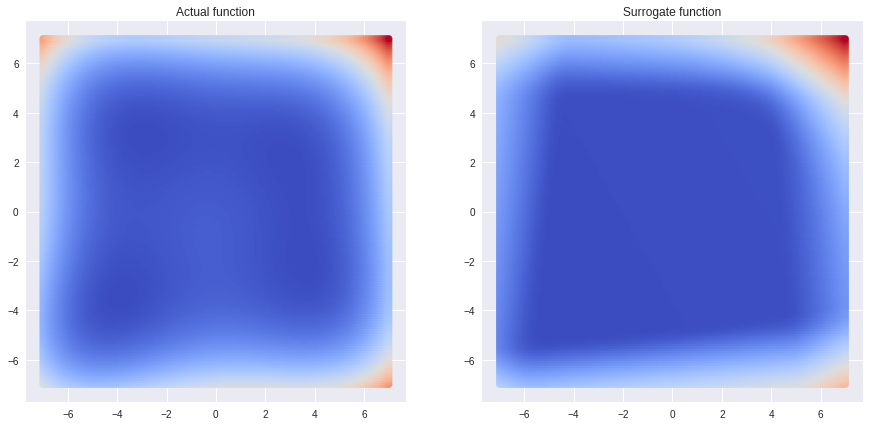

In [9]:
mlp_model = build_mlp(hidden_layers_widths, keep_prob, learning_rate)
runner = RunnerOfSurrogateModelling(
    func, noise_stddev, mlp_model, measurement_doe, optimization_doe,
    **measurement_settings)
df = runner.run_experiment(n_runs=1, runs_to_be_visualized=[0],
                           visualization_settings=optimization_settings,
                           train_settings=train_settings,
                           optimization_settings=optimization_settings)
df

TODO: KDE of estimated minimums.

# Conclusion

To be continued.